In [1]:
%pip install --upgrade "jax[cpu]"
import jax.numpy as jnp
from jax import grad # automatic differentiation -> grad = gradient
from jax.scipy.stats import norm as jnorm

%pip install blackscholes
import blackscholes as bs

%pip install yfinance
import yfinance as yf

%pip install pandas
import pandas as pd

from IPython.display import display

%pip install matplotlib
import matplotlib.pyplot as plt

%pip install numpy
import numpy as np

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
def black_scholes(S, K, T, r, sigma, q=0, otype="call"):
	d1 = (jnp.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * jnp.sqrt(T))
	d2 = d1 - sigma * jnp.sqrt(T)
	if otype == "call":
		call = S * jnp.exp(-q * T) * jnorm.cdf(d1, 0, 1) - K * jnp.exp(-r * T) * jnorm.cdf(d2 , 0, 1)
		return call
	else:
		put = K * jnp.exp(-r * T) * jnorm.cdf(-d2, 0, 1) - S * jnp.exp(-q * T) * jnorm.cdf(-d1, 0, 1)
		return put

In [3]:
S = 100
K = 110.0
T = 1.0
r = 0.05
sigma = 0.2
q = 0

otype = "call"
price = black_scholes(S, K, T, r, sigma, q, otype)
print(f"Theoretical Price: {price:.2f}")

Theoretical Price: 6.04


In [4]:
def loss(S, K, T, r, sigma_guess, price, q=0, otype="call"):

	theoretical_price = black_scholes(S, K, T, r, sigma_guess, q, otype)
	market_price = price

	# Loss is the difference between the theoretical price and the actual price
	# We want to MINIMIZE this Loss!
	return theoretical_price - market_price

loss_grad = grad(loss, argnums=4)

In [5]:
def solve_for_iv(S, K, T, r, price, sigma_guess = 1.5, q=0, otype="call", 
											N_iter = 20, epsilon = .001):

	converged = False
	# 1. Make a guess for the volatility.
	sigma = sigma_guess
	for i in range(N_iter):
			print("\nIteration: ", i)

			# 2. Calculate the loss function using our guess for sigma
			loss_val = loss(S, K, T, r, sigma, price, q=q, otype = otype)
		
			print("Current Error in Theoretical vs Market Price:")
			print(loss_val)
			
			# 3. Check if the loss is less than the tolerance, #lepsilon$.
			# If yes, STOP!
			if abs(loss_val) < epsilon:
				converged = True #abs() Restituisce sempre un numero positivo, indipendentemente dal segno
				break
			
			# If no, CONTINUE to step 4
			else:
				# 4. Calculate the gradient of the loss function
				loss_grad_val = loss_grad(S, K, T, r, sigma, price, q=q, otype=otype)
					
				# 5. Update the volatility using the Newton-Raphson formula
				sigma = sigma - loss_val / loss_grad_val
			
	if not converged:
		print ("Did not converge")
	return sigma

In [6]:
ticker = yf.Ticker("AAPL")
expirations = ticker.options
print(expirations)

('2025-07-03', '2025-07-11', '2025-07-18', '2025-07-25', '2025-08-01', '2025-08-08', '2025-08-15', '2025-09-19', '2025-10-17', '2025-11-21', '2025-12-19', '2026-01-16', '2026-02-20', '2026-03-20', '2026-05-15', '2026-06-18', '2026-09-18', '2026-12-18', '2027-01-15', '2027-06-17', '2027-12-17')


In [7]:
legth = len(expirations)
print(f"Number of expirations: {legth}")

Number of expirations: 21


In [ ]:
from datetime import datetime
#calls["Time To Expiry"] = time_to_ex
#puts["Time To Expiry"] = time_to_ex


dfs_calls = []
for exp in expirations[1:21]:
    try:
        options = ticker.option_chain(exp)
        calls = options.calls

        expiry_date = datetime.strptime(exp, "%Y-%m-%d")
        today = datetime.today()
        delta = expiry_date - today
        days_remaining = delta.total_seconds() / (24 * 3600)
        days_remaining = max(days_remaining, 0)

        calls["expiration"] = exp
        calls["Time To Expiry"] = days_remaining

        calls = calls.head(50)  # ⬅️ take first N options only

        dfs_calls.append(calls)

    except Exception as e:
        print(f"Error {exp}: {e}")



full_calls_df = pd.concat(dfs_calls, ignore_index=True)
#full_puts_df = pd.concat(dfs_puts, ignore_index=True)
calls_clean = full_calls_df.drop(columns=["impliedVolatility", "lastTradeDate"])
#puts_clean = full_puts_df.drop(columns=["impliedVolatility", "lastTradeDate"])
#print(full_calls_df["expiration"].value_counts())

display(full_calls_df.head(100))
#display(full_puts_df.head(100))

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,expiration,Time To Expiry
0,AAPL250711C00110000,2025-07-01 19:34:45+00:00,110.0,98.00,97.15,99.85,7.18,7.905748,4.0,86,1.998047,True,REGULAR,USD,2025-07-11,9.048173
1,AAPL250711C00120000,2025-06-23 13:30:54+00:00,120.0,82.00,87.20,89.90,0.00,0.000000,1.0,6,1.779298,True,REGULAR,USD,2025-07-11,9.048173
2,AAPL250711C00130000,2025-06-16 13:37:32+00:00,130.0,67.25,77.20,79.90,0.00,0.000000,4.0,4,1.552737,True,REGULAR,USD,2025-07-11,9.048173
3,AAPL250711C00135000,2025-06-27 15:04:55+00:00,135.0,66.30,72.15,74.90,0.00,0.000000,1.0,1,1.436038,True,REGULAR,USD,2025-07-11,9.048173
4,AAPL250711C00140000,2025-06-30 13:51:43+00:00,140.0,61.14,67.20,69.90,0.00,0.000000,1.0,2,1.341800,True,REGULAR,USD,2025-07-11,9.048173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,AAPL250718C00280000,2025-07-01 13:52:58+00:00,280.0,0.01,0.01,0.02,-0.01,-50.000000,13.0,5007,0.480474,False,REGULAR,USD,2025-07-18,16.048172
96,AAPL250718C00285000,2025-07-01 19:54:11+00:00,285.0,0.01,0.00,0.02,-0.01,-50.000000,42.0,5896,0.507817,False,REGULAR,USD,2025-07-18,16.048172
97,AAPL250718C00290000,2025-06-30 19:06:00+00:00,290.0,0.01,0.00,0.02,0.00,0.000000,120.0,1977,0.500005,False,REGULAR,USD,2025-07-18,16.048172
98,AAPL250725C00120000,2025-06-27 17:42:44+00:00,120.0,81.97,87.00,88.65,0.00,0.000000,5.0,5,0.656253,True,REGULAR,USD,2025-07-25,23.048171


In [9]:
legth_df = len(full_calls_df)
print(f"Number of calls: {legth_df}")

Number of calls: 899


In [10]:
print(calls.dtypes)

contractSymbol                    object
lastTradeDate        datetime64[ns, UTC]
strike                           float64
lastPrice                        float64
bid                              float64
ask                              float64
change                           float64
percentChange                    float64
volume                             int64
openInterest                       int64
impliedVolatility                float64
inTheMoney                          bool
contractSize                      object
currency                          object
expiration                        object
Time To Expiry                   float64
dtype: object


In [11]:
spot = ticker.history(period="1d")["Close"].iloc[-1]
print("Current AAPL price:", spot)

Current AAPL price: 207.82000732421875


In [12]:
for idx, row in calls_clean.iterrows():
    print(f"Row {idx}: strike={row['strike']}, expiry,={row['Time To Expiry']}, spot={spot}, spot > strike? {spot > row['strike']}")

Row 0: strike=110.0, expiry,=9.04817309644676, spot=207.82000732421875, spot > strike? True
Row 1: strike=120.0, expiry,=9.04817309644676, spot=207.82000732421875, spot > strike? True
Row 2: strike=130.0, expiry,=9.04817309644676, spot=207.82000732421875, spot > strike? True
Row 3: strike=135.0, expiry,=9.04817309644676, spot=207.82000732421875, spot > strike? True
Row 4: strike=140.0, expiry,=9.04817309644676, spot=207.82000732421875, spot > strike? True
Row 5: strike=150.0, expiry,=9.04817309644676, spot=207.82000732421875, spot > strike? True
Row 6: strike=155.0, expiry,=9.04817309644676, spot=207.82000732421875, spot > strike? True
Row 7: strike=160.0, expiry,=9.04817309644676, spot=207.82000732421875, spot > strike? True
Row 8: strike=165.0, expiry,=9.04817309644676, spot=207.82000732421875, spot > strike? True
Row 9: strike=170.0, expiry,=9.04817309644676, spot=207.82000732421875, spot > strike? True
Row 10: strike=175.0, expiry,=9.04817309644676, spot=207.82000732421875, spot > 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.

Iteration:  0
Current Error in Theoretical vs Market Price:
2.753006

Iteration:  1
Current Error in Theoretical vs Market Price:
0.5950775

Iteration:  2
Current Error in Theoretical vs Market Price:
0.12971497

Iteration:  3
Current Error in Theoretical vs Market Price:
0.018585205

Iteration:  4
Current Error in Theoretical vs Market Price:
0.0006866455

Iteration:  0
Current Error in Theoretical vs Market Price:
7.24551

Iteration:  1
Current Error in Theoretical vs Market Price:
1.0778389

Iteration:  2
Current Error in Theoretical vs Market Price:
0.19208145

Iteration:  3
Current Error in Theoretical vs Market Price:
0.019260406

Iteration:  4
Current Error in Theoretical vs Market Price:
0.00033950806

Iteration:  0
Current Error in Theoretical vs Market Price:
8.908894

Iteration:  1
Current Error in Theoretical vs Market Price:
1.1427498

Iteration:  2
Current Error in Theoretical vs Market Price:
0.19751358



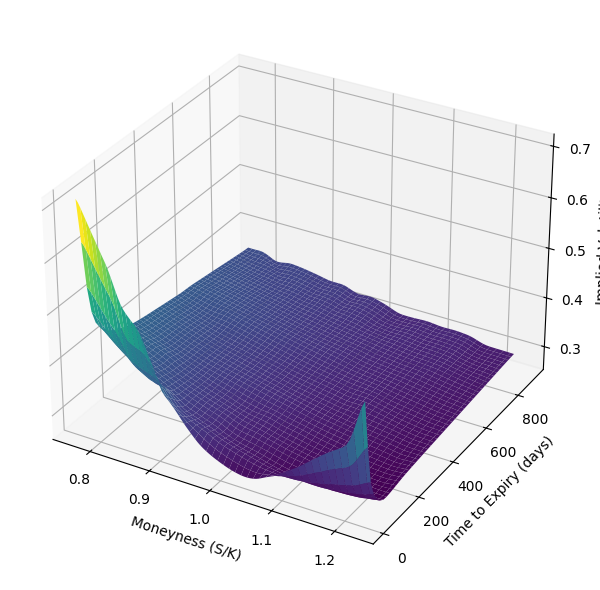

In [ ]:
%pip install scipy
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


df = calls_clean.copy()

# mid-market price
df['mid'] = (df['bid'] + df['ask']) / 2


# Apply liquidity filters: 
# 1) keep only options with open interest above 50 contractsdf = df[df['openInterest'] > 50]
# # Keep only options with strikes within ±25% of the current spot price, i.e. strikes between 75% and 125% of spot                       
df = df[np.abs(df['strike'] - spot) / spot < 0.25]      

ivs = []
for _, row in df.iterrows():
    iv = solve_for_iv(
        spot,
        row['strike'],
        row['Time To Expiry'] / 365.0,
        r=0.01,
        price=row['mid'],
        otype="call"
    )
    ivs.append(iv if np.isfinite(iv) and 0.01 < iv < 2.0 else np.nan)

df['IV'] = ivs
# Drop rows where IV calculation failed or produced NaN
df.dropna(subset=['IV'], inplace=True)

# Calculate log-moneyness k = log(strike/spot) for each point
df['k'] = np.log(df['strike'] / spot)
df['w'] = (df['IV'] ** 2) * (df['Time To Expiry'] / 365.0)


# Create matrix of points (k, T) where IVs were calculated
points = np.column_stack((df['k'].values, (df['Time To Expiry'] / 365.0).values))
values = df['IV'].values


# Define a regular grid where we will interpolate: 100 points in k, 50 in T
#IV usually varies more smoothly in time-to-expiry than in strike: the term structure doesn’t oscillate as much as the smile.
# 50 points are often enough for a smooth rendering without oversampling, which would unnecessarily slow down calculations.
m_lin = np.linspace(df['k'].min(), df['k'].max(), 100)
T_lin = np.linspace((df['Time To Expiry'] / 365.0).min(),
                    (df['Time To Expiry'] / 365.0).max(),
                    50)
Mg, Tg = np.meshgrid(m_lin, T_lin)


from scipy.ndimage import gaussian_filter
VI = griddata(points, values, (Mg, Tg), method='linear')

VI_masked = np.ma.masked_invalid(VI)


mean_val = np.nanmean(VI_masked)
VI_filled = VI_masked.filled(mean_val)


VI_smooth = gaussian_filter(VI_filled, sigma=1)

VI_smooth = np.ma.array(VI_smooth, mask=VI_masked.mask)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(
    np.exp(Mg),
    Tg * 365,
    VI_smooth,
    cmap='viridis',
    edgecolor='none'
)
ax.set_xlabel('Moneyness (S/K)')
ax.set_ylabel('Time to Expiry (days)')
ax.set_zlabel('Implied Volatility')
plt.tight_layout()
plt.show()